<a href="https://colab.research.google.com/github/james-yu2005/EMG-prediction/blob/main/KneeEMGPrediction_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, max_error, explained_variance_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

data_folder = '/content/drive/MyDrive/URA_knee_flexion_extension_NN_preprocessing_data/FinalProcessed'
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
print(len(csv_files))

Mounted at /content/drive
69


In [ ]:
# Load right knee's data
file_list = sorted(glob.glob(os.path.join(data_folder, '*_right.csv')))

# first three are all related to knee flexion and extension data of subject 1
print(file_list[:3])

# there are 23 because there are 6 subjects with type 1-3, but one subject with type 1-5 (6*3 + 5)
print(len(file_list))

['/content/drive/MyDrive/URA_knee_flexion_extension_NN_preprocessing_data/FinalProcessed/subj01_type1_1_right.csv', '/content/drive/MyDrive/URA_knee_flexion_extension_NN_preprocessing_data/FinalProcessed/subj01_type1_2_right.csv', '/content/drive/MyDrive/URA_knee_flexion_extension_NN_preprocessing_data/FinalProcessed/subj01_type1_3_right.csv']
23


In [ ]:
test_files = file_list[:3]
valid_files = file_list[3:6]
train_files = file_list[6:]

def load_sequences(file_list):
    X_seq = []
    Y_seq = []
    for file_path in file_list:
        df = pd.read_csv(file_path)

        # joint kinematics as input in type float 32
        X = df[['XR', 'dXR', 'ddXR']].values.astype(np.float32)

        # extract all right EMG columns that aren't joint kinematics and RGN (RGN isn't useful EMG data)
        emg_cols = [col for col in df.columns if col.startswith('R') and col not in ['XR', 'dXR', 'ddXR','RGN']]
        Y = df[emg_cols].values.astype(np.float32)

        X_seq.append(X)
        Y_seq.append(Y)
    return X_seq, Y_seq, emg_cols

X_train_seq, Y_train_seq, emg_cols = load_sequences(train_files)
X_valid_seq, Y_valid_seq, _ = load_sequences(valid_files)
X_test_seq, Y_test_seq, _ = load_sequences(test_files)


print(X_train_seq[0])
print(Y_train_seq[0])
print(emg_cols)

[[ 82.5334    -23.525053  429.93756  ]
 [ 82.4358    -21.66118   415.7002   ]
 [ 82.4168    -19.789736  401.28183  ]
 ...
 [ 85.3476      6.7954493  45.05481  ]
 [ 85.3048      7.0154376  45.197773 ]
 [ 85.3818      7.209156   45.314022 ]]
[[2.51212811e-07 2.72214805e-07 9.36222591e-07 0.00000000e+00
  5.97329233e-07]
 [3.67196265e-07 3.72778771e-07 9.78994194e-07 0.00000000e+00
  6.69092969e-07]
 [4.82861367e-07 4.74109243e-07 1.02186777e-06 3.52178375e-08
  7.40137978e-07]
 ...
 [5.34360606e-06 9.11691677e-06 4.43121280e-06 1.19167253e-05
  5.27049906e-06]
 [5.34360152e-06 9.11688858e-06 4.43120962e-06 1.19166853e-05
  5.27048451e-06]
 [5.34360061e-06 9.11687948e-06 4.43120871e-06 1.19166725e-05
  5.27047996e-06]]
['RRF', 'RVL', 'RVM', 'RBF', 'RSE']


In [ ]:
# Normalize EMG outputs on train sets
for i in range(3):
  print(f"Length of training sequence is: {len(Y_train_seq[i])}")

Length of training sequence is: 16818
Length of training sequence is: 15967
Length of training sequence is: 15823


In [ ]:
from sklearn.preprocessing import StandardScaler

# Since each array is a different length, use vertical stack to make them one array
all_train_Y = np.vstack(Y_train_seq)
all_valid_Y = np.vstack(Y_valid_seq)
print(len(all_train_Y))

scaler = MinMaxScaler()
scaler.fit(all_train_Y)

Y_train_seq = [scaler.transform(y) for y in Y_train_seq]
Y_valid_seq = [scaler.transform(y) for y in Y_valid_seq]

print(Y_train_seq[0])

228955
[[2.1704654e-03 1.8102841e-03 5.9406413e-03 0.0000000e+00 1.4289599e-02]
 [3.1725564e-03 2.4790552e-03 6.2120412e-03 0.0000000e+00 1.6006365e-02]
 [4.1718967e-03 3.1529234e-03 6.4840885e-03 9.4181574e-05 1.7705940e-02]
 ...
 [4.6168476e-02 6.0629360e-02 2.8117508e-02 3.1868394e-02 1.2608343e-01]
 [4.6168435e-02 6.0629174e-02 2.8117487e-02 3.1868290e-02 1.2608308e-01]
 [4.6168428e-02 6.0629115e-02 2.8117482e-02 3.1868253e-02 1.2608297e-01]]


In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, X_list, Y_list):
        self.X_list = [torch.tensor(x, dtype=torch.float32) for x in X_list]
        self.Y_list = [torch.tensor(y, dtype=torch.float32) for y in Y_list]

    def __len__(self):
        return len(self.X_list)

    def __getitem__(self, idx):
        return self.X_list[idx], self.Y_list[idx]

train_dataset = SequenceDataset(X_train_seq, Y_train_seq)
valid_dataset = SequenceDataset(X_valid_seq, Y_valid_seq)
test_dataset = SequenceDataset(X_test_seq, Y_test_seq)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
import torch
import torch.nn as nn

class EMGGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout=0.2):
        super(EMGGRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # GRU layer with dropout for regularization
        self.gru = nn.GRU(
            input_dim,
            hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Improved output layers with dropout
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(32, output_dim)
        )

    def forward(self, x):
        # x shape: [batch_size, seq_len, input_dim]
        gruout, _ = self.gru(x)  # unpack output and hidden state properly

        # Apply fully connected layers to each timestep
        out = self.fc(gruout)  # out: [batch_size, seq_len, output_dim]
        return out


# Model parameters
input_dim = 3  # kinematic features
hidden_dim = 128
output_dim = len(emg_cols)  # number of EMG channels
num_layers = 3

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = EMGGRU(input_dim, hidden_dim, output_dim, num_layers=num_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=20, verbose=True
)

Using device: cuda


In [ ]:
num_epochs = 200
train_losses = []
valid_losses = []
best_valid_loss = float('inf')
patience_counter = 0
max_patience = 40

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    total_train_points = 0

    for batch_idx, (X_seq, Y_seq) in enumerate(train_loader):
        # Move to device
        X_seq = X_seq.to(device)
        Y_seq = Y_seq.to(device)

        optimizer.zero_grad()
        output = model(X_seq)
        loss = criterion(output, Y_seq)
        loss.backward()

        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_train_loss += loss.item() * X_seq.size(1)  # scale by sequence length
        total_train_points += X_seq.size(1)

    avg_train_loss = total_train_loss / total_train_points
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    total_valid_loss = 0
    total_valid_points = 0

    with torch.no_grad():
        for X_seq, Y_seq in valid_loader:
            X_seq = X_seq.to(device)
            Y_seq = Y_seq.to(device)

            output = model(X_seq)
            loss = criterion(output, Y_seq)

            total_valid_loss += loss.item() * X_seq.size(1)
            total_valid_points += X_seq.size(1)

    avg_valid_loss = total_valid_loss / total_valid_points
    valid_losses.append(avg_valid_loss)

    # Update learning rate based on validation loss
    scheduler.step(avg_valid_loss)

    # Early stopping logic
    if avg_valid_loss < best_valid_loss:
        best_valid_loss = avg_valid_loss
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_emg_gru_model.pth')
    else:
        patience_counter += 1

    if (epoch + 1) % 5 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train MSE: {avg_train_loss:.6f}, Valid MSE: {avg_valid_loss:.6f}")

    # Early stopping
    if patience_counter >= max_patience:
        print(f"Early stopping at epoch {epoch+1} due to no improvement in validation loss")
        break

print("Training completed!")

/tmp/ipython-input-4021069054.py:25: FutureWarning: `torch.nn.utils.clip_grad_norm` is now deprecated in favor of `torch.nn.utils.clip_grad_norm_`.
  torch.nn.utils.clip_grad_norm(model.parameters(), max_norm=1.0)


Epoch 1/200, Train MSE: 0.006603, Valid MSE: 0.002412
Epoch 5/200, Train MSE: 0.003555, Valid MSE: 0.002452
Epoch 10/200, Train MSE: 0.002986, Valid MSE: 0.001984
Epoch 15/200, Train MSE: 0.002530, Valid MSE: 0.002277
Epoch 20/200, Train MSE: 0.002489, Valid MSE: 0.002094
Epoch 25/200, Train MSE: 0.002168, Valid MSE: 0.002285
Epoch 30/200, Train MSE: 0.002129, Valid MSE: 0.002555
Epoch 35/200, Train MSE: 0.001990, Valid MSE: 0.002358
Epoch 40/200, Train MSE: 0.001805, Valid MSE: 0.002327
Epoch 45/200, Train MSE: 0.001766, Valid MSE: 0.002320
Epoch 50/200, Train MSE: 0.001730, Valid MSE: 0.002395
Early stopping at epoch 51 due to no improvement in validation loss
Training completed!


In [ ]:
model.eval()
Y_true_all = []
Y_pred_all = []

# Predict for all test sequences
with torch.no_grad():
    for X_seq, Y_seq in test_loader:
        X_seq = X_seq.to(device)
        Y_seq = Y_seq.to(device)

        pred = model(X_seq).squeeze(0).cpu().numpy()  # bring back to CPU for numpy
        true = Y_seq.squeeze(0).cpu().numpy()

        # Since prediction will be scaled as model is trained on scaled train and valid datasets, must unscale the prediction
        pred_unscaled = scaler.inverse_transform(pred)

        # add them to the appropriate array
        Y_pred_all.append(pred_unscaled)
        Y_true_all.append(true)

# Stack the predictions and ground truths vertically
Y_true_stacked = np.vstack(Y_true_all)  # shape: [total_timepoints, num_channels]
Y_pred_stacked = np.vstack(Y_pred_all)

print("Detailed regression metrics per EMG channel in original scale:")

for i, label in enumerate(emg_cols):
    y_true = Y_true_stacked[:, i]
    y_pred = Y_pred_stacked[:, i]

    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    ev = explained_variance_score(y_true, y_pred)
    max_err = max_error(y_true, y_pred)

    print(f"\nChannel: {label}")
    print(f"  MSE:  {mse:.14f}")
    print(f"  RMSE: {rmse:.14f}")
    print(f"  MAE:  {mae:.14f}")
    print(f"  R²:   {r2:.14f}")
    print(f"  Explained Variance: {ev:.14f}")
    print(f"  Max Error: {max_err:.14f}")

Detailed regression metrics per EMG channel in original scale:

Channel: RRF
  MSE:  0.00000000001248
  RMSE: 0.00000353283663
  MAE:  0.00000267594601
  R²:   0.60763227939606
  Explained Variance: 0.70674252510071
  Max Error: 0.00002907968883

Channel: RVL
  MSE:  0.00000000000879
  RMSE: 0.00000296404862
  MAE:  0.00000220109882
  R²:   0.42279714345932
  Explained Variance: 0.48162716627121
  Max Error: 0.00001708192940

Channel: RVM
  MSE:  0.00000000001076
  RMSE: 0.00000328078057
  MAE:  0.00000205212427
  R²:   0.51143968105316
  Explained Variance: 0.60167217254639
  Max Error: 0.00002930405208

Channel: RBF
  MSE:  0.00000000002001
  RMSE: 0.00000447307902
  MAE:  0.00000351153767
  R²:   -2.10356020927429
  Explained Variance: -1.48833990097046
  Max Error: 0.00003073304833

Channel: RSE
  MSE:  0.00000000000903
  RMSE: 0.00000300578153
  MAE:  0.00000250521748
  R²:   -4.57053756713867
  Explained Variance: -1.17813706398010
  Max Error: 0.00000878895480


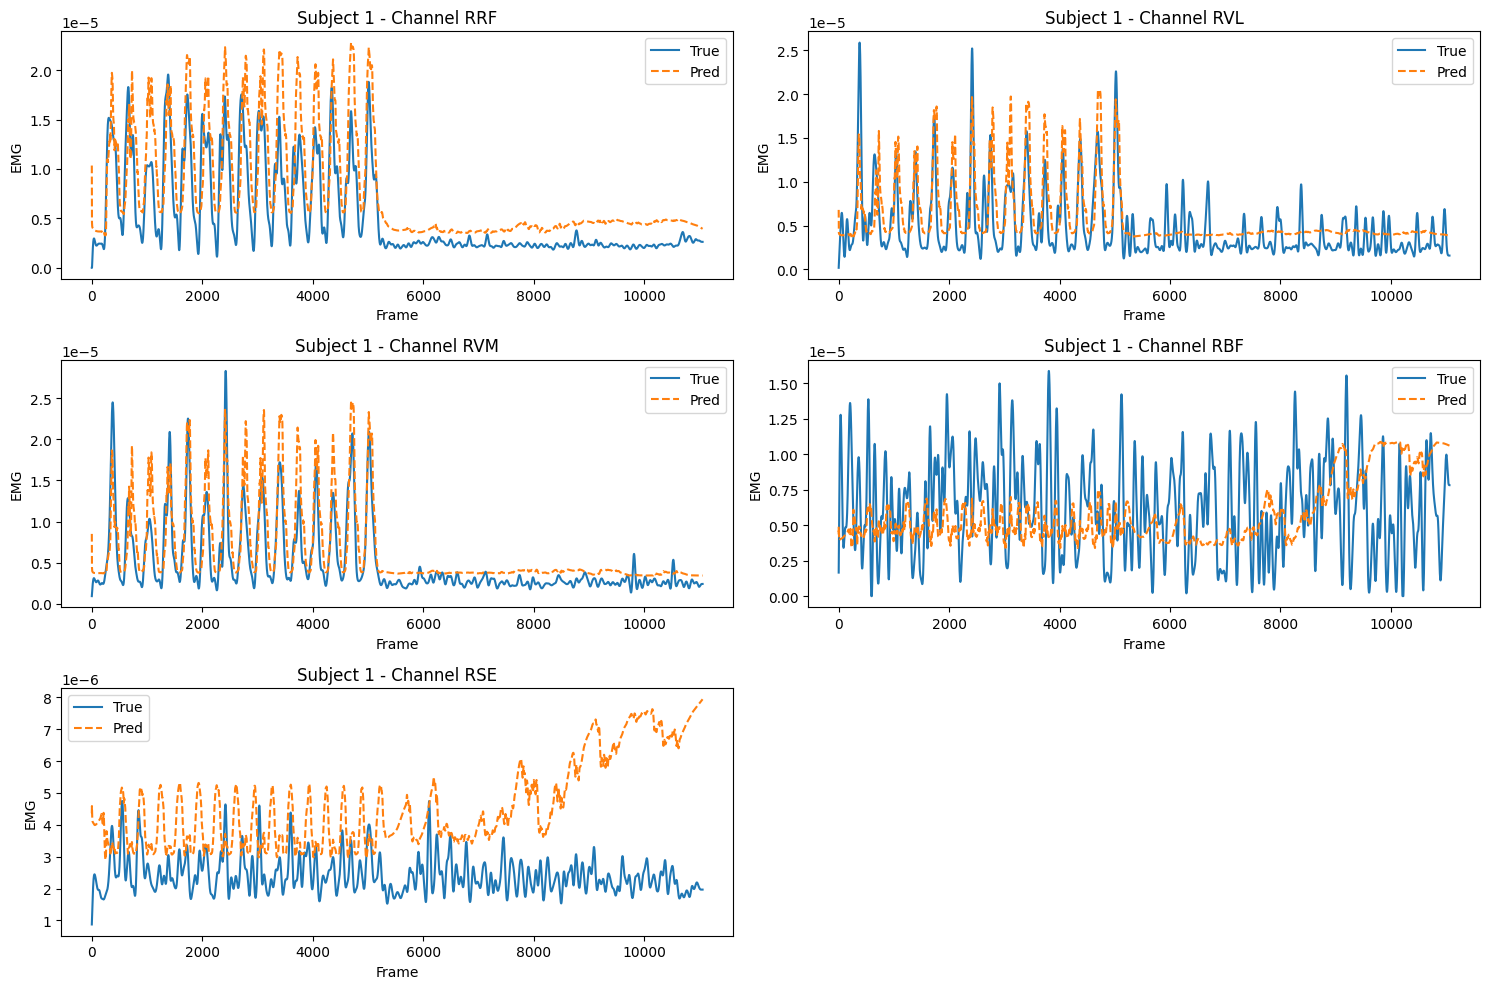

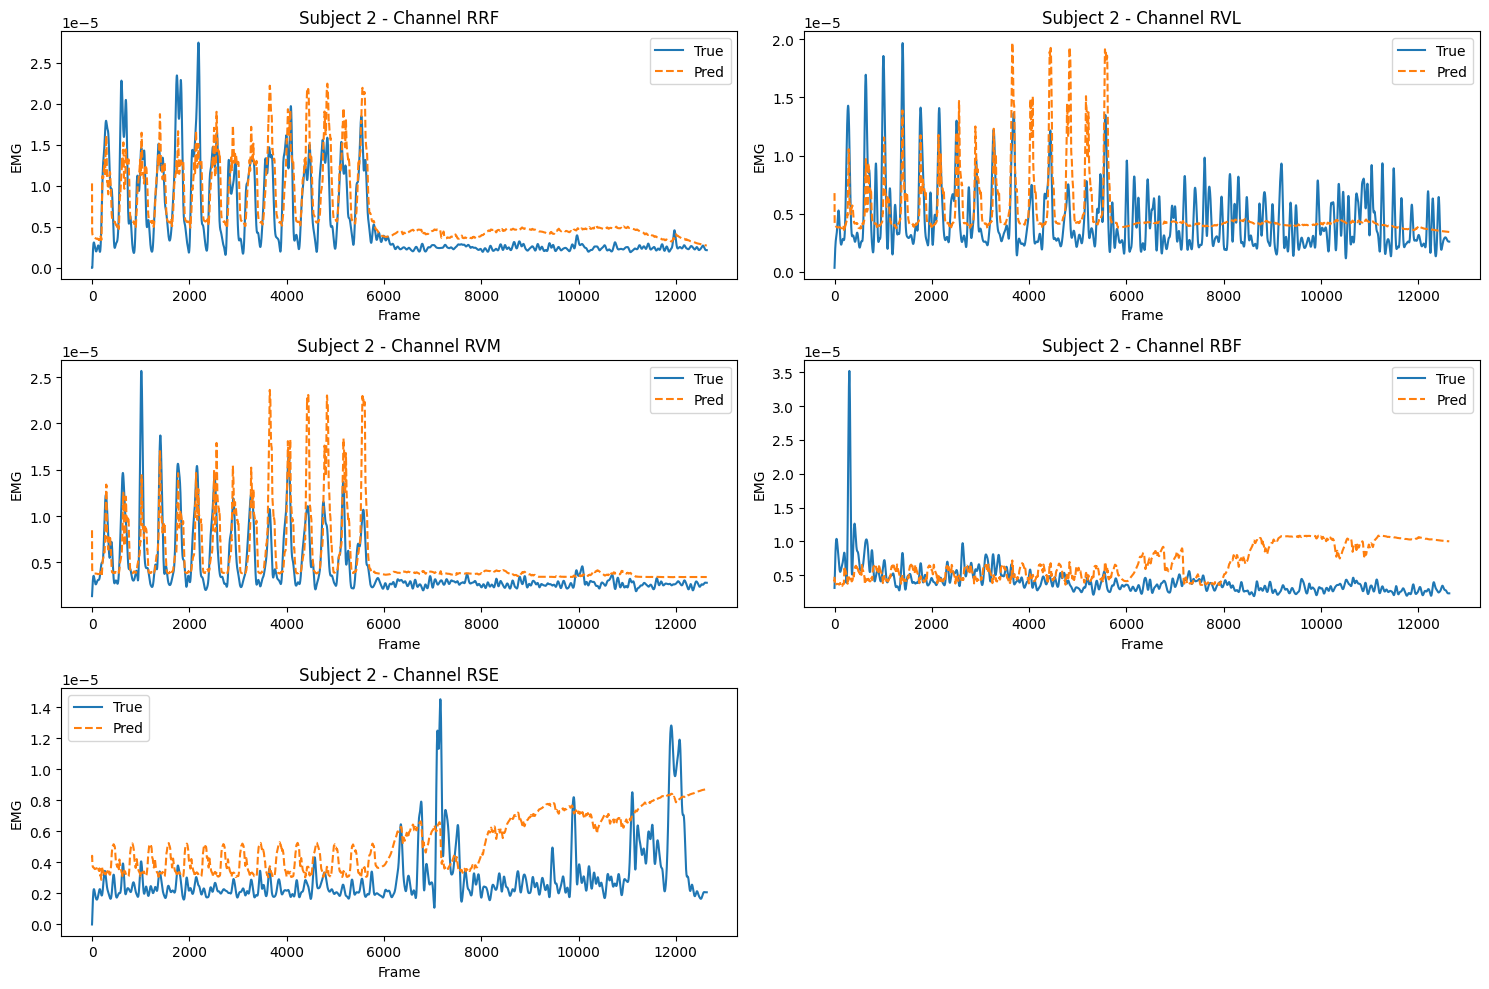

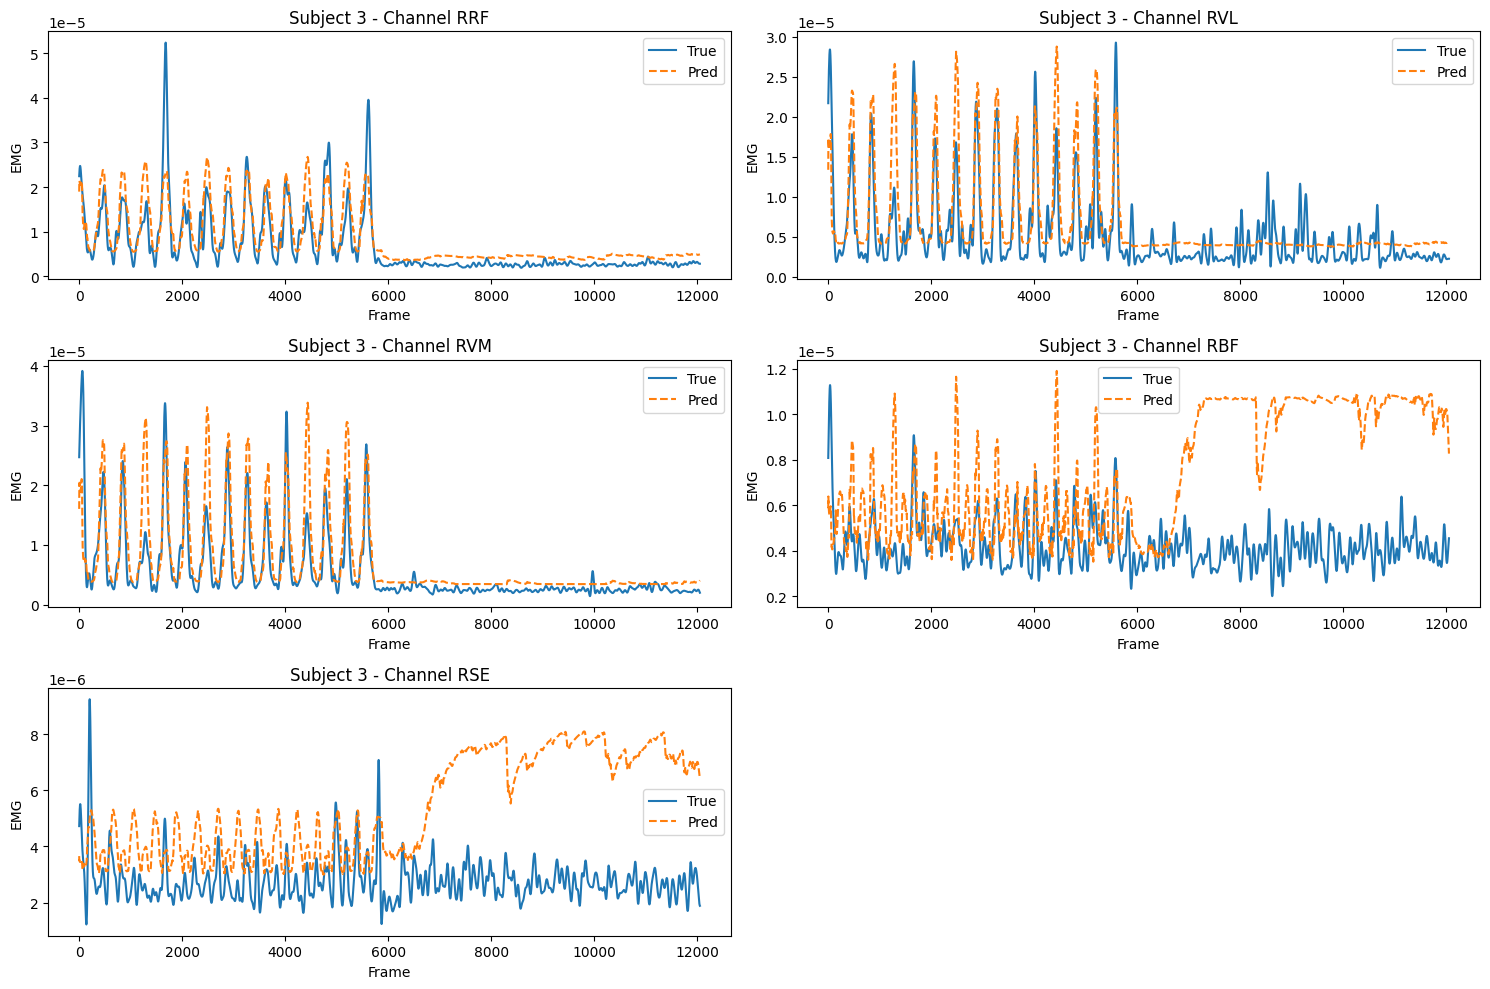

In [ ]:
# Plot prediction and ground truths for each EMG channel for each of 3 test data
for trial in range(len(Y_true_all)):
    # pred and true hold the predicted and true values for the specific trial of test data
    pred = Y_pred_all[trial]
    true = Y_true_all[trial]

    # time is x axis
    time = np.arange(true.shape[0])

    plt.figure(figsize=(15, 10))
    # Loop through each EMG channel because true is of shape (time stamps, EMG Channels) -> (time stamps, 5)
    for ch in range(true.shape[1]):
        plt.subplot((true.shape[1]+1)//2, 2, ch+1)

        # Plot all the rows associated with that EMG channel index
        plt.plot(time, true[:, ch], label="True")
        plt.plot(time, pred[:, ch], label="Pred", linestyle="--")

        plt.title(f"Subject {trial+1} - Channel {emg_cols[ch]}")
        plt.xlabel("Frame")
        plt.ylabel("EMG")
        plt.legend()

    plt.tight_layout()
    plt.show()

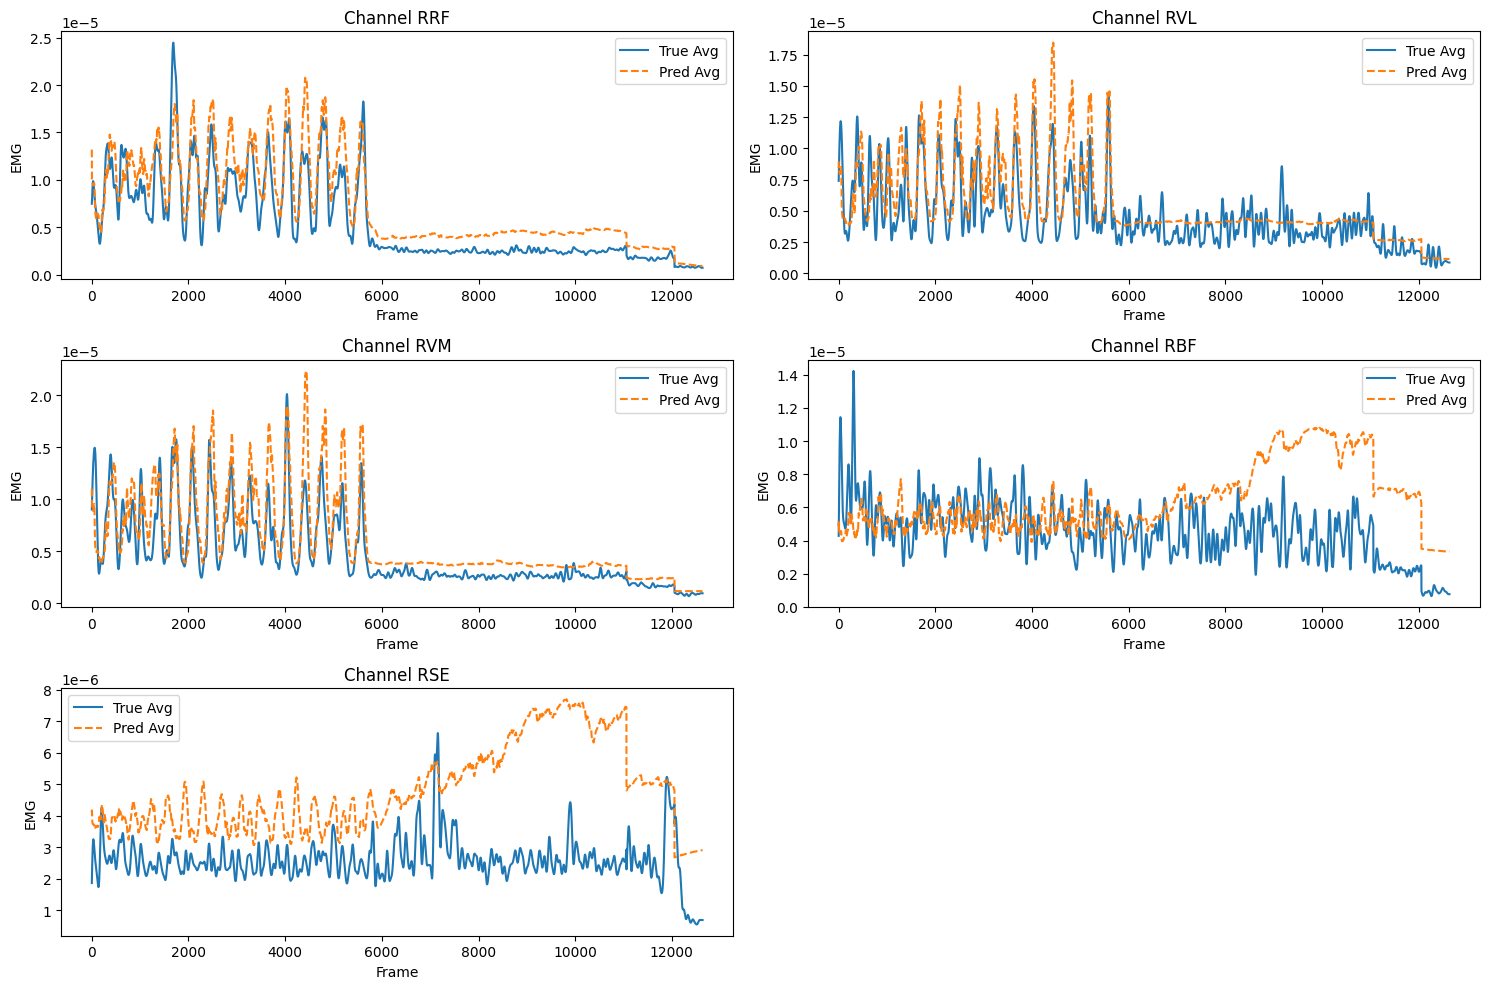

In [ ]:
# Plot average of three trials for EMG channels
max_len_timestamps = max(arr.shape[0] for arr in Y_true_all)

EMG_channels = Y_true_all[0].shape[1]

true_stack = np.zeros((len(Y_true_all), max_len_timestamps, EMG_channels))
pred_stack = np.zeros((len(Y_pred_all), max_len_timestamps, EMG_channels))

# Fill with actual data, leave padding as zeros
for i, arr in enumerate(Y_true_all):
    true_stack[i, :arr.shape[0], :] = arr
for i, arr in enumerate(Y_pred_all):
    pred_stack[i, :arr.shape[0], :] = arr

# Now average over subjects
true_avg = np.mean(true_stack, axis=0)  # shape: (max_len, channels)
pred_avg = np.mean(pred_stack, axis=0)  # shape: (max_len, channels)

# Plot
time = np.arange(true_avg.shape[0])
plt.figure(figsize=(15, 10))
for ch in range(true_avg.shape[1]):
    plt.subplot((true_avg.shape[1]+1)//2, 2, ch+1)
    plt.plot(time, true_avg[:, ch], label="True Avg")
    plt.plot(time, pred_avg[:, ch], label="Pred Avg", linestyle="--")
    plt.title(f"Channel {emg_cols[ch]}")
    plt.xlabel("Frame")
    plt.ylabel("EMG")
    plt.legend()

plt.tight_layout()
plt.show()